# Scaling up compute - Working with CM2.6

This is a supposed to be a 'real-life' science workflow example. No tiny well-behaved test cases. Instead you will see an approximation of how your science project could evolve, based on some of my experiences. The actual results do however not make a lot of sense, so there is still some work needed 😜. 

I will try to convey some core concepts that hopefully convince you of the awesomeness of **Analysis-Ready Cloud Optimized** (ARCO) data + flexible/scalable cloud computing:

- Quickly loading/exploring huge datasets without *downloading them*

- Analysis, scaled on demand, transitioning from exploration to heavy processing in minutes.

As an example I have chosen to work on the [NOAA-GFDL CM2.6 high resolution coupled climate simulation](https://www.gfdl.noaa.gov/high-resolution-climate-modeling/). 

## Reading the data (lazily)

In [1]:
# copy and paste
import xarray as xr

url = "gs://cmip6/GFDL_CM2_6/control/surface"
ds = xr.open_dataset(url, engine="zarr", chunks={}, use_cftime=True)
# to save time Ill cut the time to 10 years for the demo
ds = ds.isel(time=slice(0,3650))
ds

<xarray.Dataset> Size: 2TB
Dimensions:         (time: 3650, yt_ocean: 2700, xt_ocean: 3600,
                     st_ocean_sub01: 1, nv: 2, yu_ocean: 2700, xu_ocean: 3600)
Coordinates:
  * nv              (nv) float64 16B 1.0 2.0
  * st_ocean_sub01  (st_ocean_sub01) float64 8B 5.034
  * time            (time) object 29kB 0181-01-01 12:00:00 ... 0190-12-29 12:...
  * xt_ocean        (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean        (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables: (12/14)
    biomass_p       (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    chl             (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    dic             (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    htotal          (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    irr_mix         (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    kw              (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...              ...
    sea_level       (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sea_level_sq    (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_salt    (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp    (time, yt_ocean, xt_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    usurf           (time, yu_ocean, xu_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    vsurf           (time, yu_ocean, xu_ocean) float32 142GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_minibling_surf_field.nc
    grid_tile:  1
    grid_type:  mosaic
    history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
    title:      CM2.6_miniBling

## Exploring the data

### A quick plot

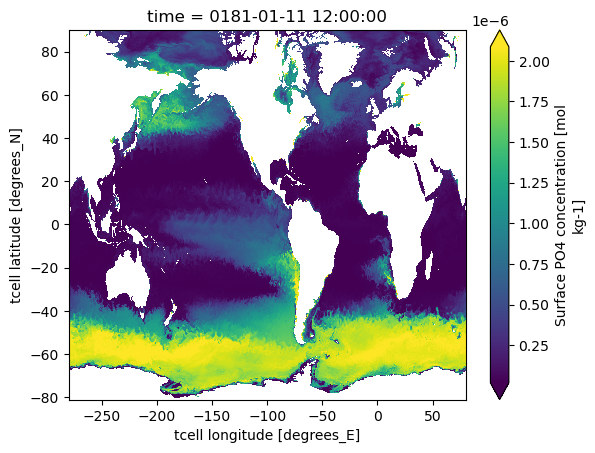

In [2]:
ds.po4.isel(time=10).plot(robust=True)

### Something a bit more exciting

[hvplot docs](https://hvplot.holoviz.org/index.html)

In [3]:
import hvplot.xarray

In [4]:
ds.surface_salt.isel(time=slice(0, 200)).hvplot(
    groupby=["time"], rasterize=True, x="xt_ocean", y="yt_ocean"
)

:DynamicMap   [time]
   :Image   [xt_ocean,yt_ocean]   (surface_salt)

## Moving from exploration to processing large amounts of data
So far all of the data has been streamed on demand. We only load the data when we plot e.g. a certain time slice

Lets run a bit larger computation

In [5]:
# this is lazy (the array is still a dask array)
ds.surface_temp.mean()

<xarray.DataArray 'surface_temp' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [6]:
#from dask.diagnostics import ProgressBar
#with ProgressBar():
    # This is loaded into memory (processing the full data array) and showing a numpy array#
#    display(ds.surface_temp.mean().load())

This will eventually finish...

...but I **hate** waiting!

![](https://media.giphy.com/media/d31vwWHR0gLcLU76/giphy.gif)

This is using dask under the hood to parallelize the computation, but there is only so much we can do with 4 CPU cores (or up to 16 depending on the server you chose). After all we are averaging 300GB! here. 

Depending on the dataset size it might be worth getting a distributed dask cluster set up. 

In [7]:
# lets get some help
from dask_gateway import Gateway
gateway = Gateway()

# specify memory per worker
options = gateway.cluster_options()
options.worker_resource_allocation = '16CPU, 115.8Gi'
options

In [8]:
cluster = gateway.new_cluster(options)

cluster.scale(10) # get a fixed number of workers
# cluster.adapt(1, 6) # scale workers based on load
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ed5899a10f764bc08a795134584a1bbb/status,


**Make sure to copy the link 👆 into the dask sidebar**

So wait, what is happening here? 

By starting a Gateway cluster, we provisioned more kubernetes nodes in the cloud which run dask and can do work (we got 10*16 cores) for us as instructed from this notebook (which only has a few cores)!


This might take a few minutes to start up, but is definitely worth it for very large computations. 

In [9]:
grid = xr.open_dataset('gs://cmip6/GFDL_CM2_6/grid', engine='zarr') 
grid

<xarray.Dataset> Size: 1GB
Dimensions:         (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                     xu_ocean: 3600, st_edges_ocean: 51, st_ocean: 50,
                     sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/27)
    area_t          (yt_ocean, xt_ocean) float32 39MB ...
    area_u          (yu_ocean, xu_ocean) float32 39MB ...
    dxt             (yt_ocean, xt_ocean) float64 78MB ...
    dxu             (yu_ocean, xu_ocean) float64 78MB ...
    dyt             (yt_ocean, xt_ocean) float64 78MB ...
    dyu             (yu_ocean, xu_ocean) float64 78MB ...
    ...              ...
  * sw_ocean        (sw_ocean) float64 400B 10.07 20.16 ... 5.29e+03 5.5e+03
    wet             (yt_ocean, xt_ocean) float64 78MB ...
  * xt_ocean        (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean        (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables:
    *empty*
Attributes:
    NCO:      4.0.3

In [ ]:
temp_mean = ds.surface_temp.weighted(grid.area_t).mean().load()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 38.57 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
temp_mean

## How about some filtering?

Following the example in the [gcm-filters docs](https://gcm-filters.readthedocs.io/en/latest/gpu.html#filtering-on-cpus-versus-gpus).

In [ ]:
wet_mask = (grid.kmt>0).astype(int)
wet_mask.plot()

In [ ]:
area = grid.area_t

In [ ]:
import gcm_filters
specs = {
    'filter_scale': 10,
    'dx_min': 1,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'grid_type': gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED
}

In [ ]:
f = gcm_filters.Filter(grid_vars={'area': area, 'wet_mask': wet_mask}, **specs)

In [ ]:
filtered_sst = f.apply(ds.surface_temp.chunk({'yt_ocean':-1}), dims=['xt_ocean', 'yt_ocean'])
filtered_sst

In [ ]:
small_sst = (ds.surface_temp - filtered_sst)
small_sst

In [ ]:
small_sst.isel(time=30).plot(robust=True, x='xt_ocean', figsize=[16,7])

In [ ]:
small_sst_variance = (small_sst**2).coarsen(xt_ocean=10, yt_ocean=10).mean()

In [ ]:
small_sst_variance.isel(time=100).plot(robust=True)

In [ ]:
mean_small_sst_variance = small_sst_variance.isel(time=slice(0,500)).mean(['xt_ocean', 'yt_ocean']).load()

In [ ]:
mean_small_sst_variance.plot()

Is this a meaningful result? 🤷‍♂️

Should we have weighted by the cell area? 💯

Nonetheless this should be similar to many real-world workflows, and shows the power of scalable compute for more complex analysis tasks.

> A word of caution re dask and layering many lazy computations: A common issue when layering many different opations (particularly some that require rechunking!) is that dask worker memory will blow up and the workers will die. Depending on your workflow saving/loading intermediate zarr arrays might be the most practical workaround. 

In [ ]:
# lets write the results out
mean_small_sst_variance.to_dataset(name='mean_small_sst_variance').to_zarr('gs://leap-scratch/jbusecke/demo_write.zarr')

In [ ]:
test_reload = xr.open_dataset('gs://leap-scratch/jbusecke/demo_write.zarr', engine='zarr')
test_reload

In [ ]:
mean_small_sst_variance.plot()
test_reload['mean_small_sst_variance'].plot(ls='--')

## Oh wait, my original dataset is not enough. 

I just figured out I need to look at some renalysis data 😱

But it turns out someone else has already [ingested ERA5 for us](https://github.com/google-research/arco-era5) so we can continue the ARCO awesomeness!

In [ ]:
import xarray
era5 = xarray.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks={'time': 48},
    consolidated=True,
)
era5 = era5.isel(time=slice(0, 50000))
era5

In [ ]:
era5['2m_temperature']

In [ ]:
mean_era5 = era5['2m_temperature'].mean('time').load()

In [ ]:
mean_era5.plot(robust=True)

In [ ]:
cluster.shutdown()